# softmax回归的从零开始实现

In [17]:
import collections
import math
import os
import random
import sys
import tarfile
import time
import json
import zipfile
from tqdm import tqdm
from PIL import Image
from collections import namedtuple

from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchtext
import torchtext.vocab as Vocab
import numpy as np


## 获取和读取数据
在这里我们使用Fashion-MNIST数据集，并设置批量大小为256。

In [2]:
def load_data_fashion_mnist(batch_size, root='~/Datasets/FashionMNIST'):
    """Download the fashion mnist dataset and then load into memory."""
    transform = transforms.ToTensor()
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)
    if sys.platform.startswith('win'):
        num_workers = 0  # 0表示不用额外的进程来加速读取数据
    else:
        num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_iter, test_iter

In [5]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 初始化模型参数
我们用向量表示每个样本。已知每个样本输入是高和宽均为28像素的图像。模型的输入向量长度为$28\times 28 = 784$：该向量的每个元素对应图像中每个像素。由于图像有10个类别，单层神经网络输出层的输出个数为10，因此softmax回归的权重和偏差参数分别为$784\times 10 和 1\times 10$的矩阵。

In [6]:
num_inputs = 784
num_outputs = 10
W = torch.tensor(np.random.normal(0, 0.01,(num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

和之前一样，我们需要模型参数梯度。

## 实现softmax运算

In [7]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim = 1, keepdim = True)
    return X_exp / partition # 这里应用广播机制

In [8]:
# 一个小例子
X = torch.rand((2,5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim = 1))

tensor([[0.2039, 0.1487, 0.2878, 0.2299, 0.1296],
        [0.2012, 0.1195, 0.2984, 0.2498, 0.1310]]) tensor([1.0000, 1.0000])


## 定义模型
通过`view`函数将每张原始图改成长度为`num_inputs`的向量

In [9]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)),W)+b)

## 定义损失函数
使用`gather`函数得到标签的预测概率。

In [10]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(1, y.view(-1, 1)))

## 计算分类准确率

In [11]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1)==y).float().mean().item()

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1)==y).float().sum().item()
        n+=y.shape[0]
    return acc_sum/n

In [12]:
print(evaluate_accuracy(test_iter, net))

0.1377


## 训练模型

In [14]:
num_epochs, lr = 10, 0.1

def sgd(params, lr, batch_size):
    # 为了和原书保持一致，这里除以了batch_size，但是应该是不用除的，因为一般用PyTorch计算loss时就默认已经
    # 沿batch维求了平均了。
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data


# 本函数已保存在d2lzh包中方便以后使用
def train(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            for param in params:
                param.grad.data.zero_()

            l.backward()
            sgd(params, lr, batch_size)


            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)


epoch 1, loss 0.4274, train acc 0.854, test acc 0.837
epoch 2, loss 0.4250, train acc 0.856, test acc 0.840
epoch 3, loss 0.4238, train acc 0.856, test acc 0.841
epoch 4, loss 0.4221, train acc 0.856, test acc 0.840
epoch 5, loss 0.4195, train acc 0.856, test acc 0.841
epoch 6, loss 0.4179, train acc 0.858, test acc 0.840
epoch 7, loss 0.4180, train acc 0.857, test acc 0.838
epoch 8, loss 0.4146, train acc 0.859, test acc 0.840
epoch 9, loss 0.4144, train acc 0.859, test acc 0.842
epoch 10, loss 0.4129, train acc 0.859, test acc 0.842


In [18]:
from IPython import display
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def use_svg_display():
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')

C:\Users\ZHANGWEIMING\AppData\Local\Temp\ipykernel_19336\3265950703.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


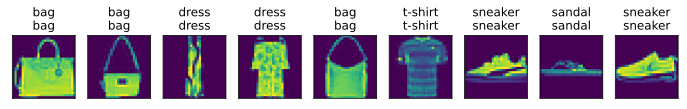

In [19]:
X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[30:39], titles[30:39])
